# **Testing the Simulator**

In [1]:
import numpy as np
import sys
from importlib import reload

sys.path.append("..")
import tools.mc as mc
import tools.utils as utils
reload(mc)
reload(utils)

<module 'tools.utils' from '../tools/utils.py'>

In [2]:
import simulator
reload(simulator)

<module 'simulator' from '/home/levente/Egyetem/PhD/kutatas/pards/src/simulation/simulator.py'>

In [10]:
P = np.array([[0, 0.75, 0.25],
              [0.5, 0, 0.5],
              [0.75, 0.25, 0]])

## **Testing the sampler**

In [7]:
#Test case 1:
#1 state, initial state is 0
#carrying out multiple samplings, that must represent [0, 0.75, 0.25] vector

results = [0, 0, 0]
state = [0]
N_SAMPLES = 10000
for i in range(N_SAMPLES):
    result = mc_sampler.sample_chain(P, state)[0]
    results[result] = results[result]+1
    
print("{:.2f}, {:.2f}, {:.2f}".format(results[0]/N_SAMPLES, results[1]/N_SAMPLES, results[2]/N_SAMPLES))

0.00, 0.75, 0.25


In [8]:
#Test case 2:
#2 states, initial state is 0, 1
#carrying out multiple samplings, that must represent [0, 0.75, 0.25], [0.5, 0, 0.5] vectors

results = [[0, 0, 0], [0, 0, 0]]
state = [0, 1]
N_SAMPLES = 10000
for i in range(N_SAMPLES):
    result = mc_sampler.sample_chain(P, state)
    for r in range(2):
        results[r][result[r]] = results[r][result[r]]+1
    
print("{:.2f}, {:.2f}, {:.2f}".format(results[0][0]/N_SAMPLES, results[0][1]/N_SAMPLES, results[0][2]/N_SAMPLES))
print("{:.2f}, {:.2f}, {:.2f}".format(results[1][0]/N_SAMPLES, results[1][1]/N_SAMPLES, results[1][2]/N_SAMPLES))

0.00, 0.76, 0.24
0.50, 0.00, 0.50


In [4]:
#Test case 3
#Long run test
#starting from the initial state, making huge amount of steps
#resulting vector shall represent the stationary distribution

π = mc.calculate_stationary_distribution(P)

results = [0, 0, 0]
state = [0]
N_SAMPLES = int(1e6)
for i in range(N_SAMPLES):
    result = mc_sampler.sample_chain(P, state)[0]
    state = [result]
    results[result] = results[result]+1
    
print("expected\t\t", π)
print("test result\t\t{:.2f}, {:.2f}, {:.2f}".format(results[0]/N_SAMPLES, results[1]/N_SAMPLES, results[2]/N_SAMPLES))

expected		 [0.37837838 0.35135135 0.27027027]
test result		0.38, 0.35, 0.27


---
## **Testing the Simulator**

In [4]:
class PassTracer:
    states = [0,0,0]
    ids = {}
    
    def __call__(self, t, states, ids, remainings):
        for st in states:
            st = int(st)
            self.states[st] = self.states[st] + 1
        for _id in ids:
            self.ids[_id] = True

In [6]:
# Test case 1
# Simple simulation run, with 1 object
# Feeding in only in the first step
# Starting from state 1
# Path length 1000 steps

feeding_model = [1]
initial_state_model = [1, 0, 0]
path_length_model = np.zeros(1000)
path_length_model[999] = 1.0
pass_tracer = PassTracer()

sim = simulator.Simulator(P, feeding_model, initial_state_model, path_length_model)
run_steps = sim.simulate(callback_function = pass_tracer)
print("Simulator finished in {} steps".format(run_steps))

Simulator finished in 999 steps


In [7]:
print("test result\t\t{:.2f}, {:.2f}, {:.2f}".format(pass_tracer.states[0]/run_steps,
                                                     pass_tracer.states[1]/run_steps,
                                                     pass_tracer.states[2]/run_steps))

test result		0.39, 0.35, 0.26


In [5]:
# Test case 2
# Simple simulation run, with many objects
# Feeding in only in the first 100 steps
# Starting from each states equiprobably
# Path lengths 100 steps

feeding_model = np.ones(100)*15
initial_state_model = [1/3, 1/3, 1/3]
path_length_model = np.zeros(100)
path_length_model[99] = 1.0
pass_tracer = PassTracer()

sim = simulator.Simulator(P, feeding_model, initial_state_model, path_length_model)
run_steps = sim.simulate(callback_function = pass_tracer)
print("Simulator finished in {} steps".format(run_steps))

Simulator finished in 198 steps


In [7]:
print("test result (reached states)\t\t{:.2f}, {:.2f}, {:.2f}".format(pass_tracer.states[0]/np.sum(pass_tracer.states),
                                                     pass_tracer.states[1]/np.sum(pass_tracer.states),
                                                     pass_tracer.states[2]/np.sum(pass_tracer.states)))
print("test max id\t\t{}".format(max(list(pass_tracer.ids.keys()))))

test result (reached states)		0.38, 0.35, 0.27
test max id		1499.0


### **Checking distribution of remaining distances**

In [11]:
# Test case 3
# Given a realistic path length model, we collect the remaining lengths upon meetings
# Meeting=being in the same state

In [3]:
def sample_lengths(a, num_samples):
    p_m = 1/a
    ds = np.arange(1, 2*a+1)
    p_d = np.array([2*p_m/a*d if d<=a/2 else -2*p_m/(3*a)*d+4/3*p_m for d in ds])
    return np.random.choice(ds, num_samples, p=p_d) 

In [3]:
def sample_lengths(a, num_samples):
    p_m = 1/a
    ds = np.arange(1, 2*a+1)
    p_d = np.array([1/(a**2)*d if d<=a else -1/(a**2)*d+2/a for d in ds])
    return np.random.choice(ds, num_samples, p=p_d)

/home/levente/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Histogram of route lengths')

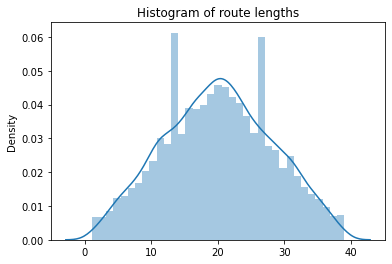

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

route_length = sample_lengths(20, 10000)

sns.distplot(route_length)
plt.title("Histogram of route lengths")

In [10]:
route_length
max(route_length)
min(route_length)

1

In [90]:
sys.path.append("..")
import meeting_model
reload(meeting_model)

class CounterCallback:
    remaining_at_meeting = []
    def __init__(self, edge_to_index_map, index_to_edge_map):
        '''
            Parameters:
                edge_to_index_map: network edges -> indices of P
                index_to_edge_map: indices of P -> network edges
        '''
        
        self.meeting_model = meeting_model.Meeting(edge_to_index_map, index_to_edge_map)
    
    def __call__(self, t, states, ids, remainings):
        if (t%10 == 0): 
            print("Step %d\trunning %d"%(t, len(states)))
            print("Remaining:\t", remainings[-10:])
        meetings = self.meeting_model(t, states, ids, remainings)
        for x,y in meetings:
            x = int(x)
            self.remaining_at_meeting.append(remainings[x]) #as meetings contains pairs in both order

In [91]:
feeding_model = np.ones(100)*50

P, edge_to_index_map, index_to_edge_map = utils.read_MC("../../data/large_grid2.net.xml",
                                                       "../../data/turnings.xml",
                                                       [.15, .8, .05])
P_ = mc.add_st_node(P, [0.0, 0.0])
π = mc.calculate_stationary_distribution(P_)
initial_state_model = π

a = 20
p_m = 1/a
ds = np.arange(1, 2*a+1)
p_d = np.array([2*p_m/a*d if d<=a/2 else -2*p_m/(3*a)*d+4/3*p_m for d in ds])
path_length_model = p_d

counter = CounterCallback(edge_to_index_map, index_to_edge_map)

sim = simulator.Simulator(P_, feeding_model, initial_state_model, path_length_model)
run_steps = sim.simulate(callback_function = counter)
print("Simulator finished in {} steps".format(run_steps))

Step 0	running 50
Remaining:	 [12. 10. 15.  6. 16. 31. 24. 18. 27. 15.]
Step 10	running 481
Remaining:	 [ 6. 39. 21. 20. 10.  9.  9.  9. 21. 17.]
Step 20	running 729
Remaining:	 [26. 27. 16. 10. 25.  8.  5. 18.  9. 15.]
Step 30	running 810
Remaining:	 [23. 28. 15.  6. 10. 16. 11. 32. 18.  1.]
Step 40	running 844
Remaining:	 [25.  7.  7. 13. 10. 13. 23. 12. 20. 18.]
Step 50	running 831
Remaining:	 [10. 25. 32. 12. 21. 12. 26. 31. 22.  4.]
Step 60	running 831
Remaining:	 [17. 16.  2. 11.  9. 23.  3. 36. 25.  9.]
Step 70	running 849
Remaining:	 [ 9. 12. 29. 35. 23.  4.  7. 17.  6. 18.]
Step 80	running 845
Remaining:	 [16.  4. 30. 30. 11.  6. 25.  7.  8. 14.]
Step 90	running 852
Remaining:	 [11.  8. 10.  8. 29. 21. 13.  5. 15. 24.]
Step 100	running 797
Remaining:	 [ 6. 14. 31. 17. 17.  7. 16. 12.  3. 15.]
Step 110	running 354
Remaining:	 [13. 16.  2.  4. 21.  7.  7.  6.  2.  5.]
Step 120	running 99
Remaining:	 [10. 12.  5. 11.  5. 12. 13.  3.  6. 11.]
Step 130	running 16
Remaining:	 [5. 5.

/home/levente/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


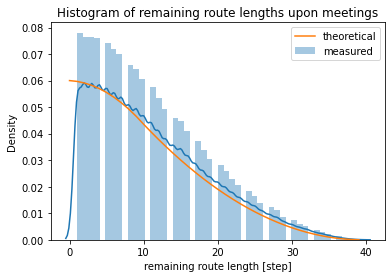

In [116]:
sns.distplot(counter.remaining_at_meeting, label="measured")
plt.plot(np.cumsum(p_d[::-1])[::-1]/np.sum(np.cumsum(p_d[::-1])[::-1]), label="theoretical")
plt.title("Histogram of remaining route lengths upon meetings")
plt.xlabel("remaining route length [step]")
plt.legend()

In [117]:
np.sum(np.arange(0, 40)*p_d) #expected value of p_d

15.666666666666664